# Setup

The [RDKit library](https://github.com/rdkit/rdkit) provides a convenient, robust, and well tested interface for manipulating and drawing molecules.

In [1]:
from rdkit.Chem import MolFromMolFile
from rdkit import RDLogger                                                                                                                                                               
from pathlib import Path
from pprint import pprint
from utils import *
from collections import namedtuple
import networkx as nx
import random
import time
RDLogger.DisableLog('rdApp.*')

MOLFILEPATH = "../test/testfiles"

# Canonicalization

## Molecule partitioning
The goal is to divide atoms in equivalence-classes / partitions.

First, sort the atoms by "atomic number fingerprint" (elaborate).

original
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               6 │           0 │ [(1, 6, 0), (5, 6, 0), (11, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               6 │           0 │ [(0, 6, 0), (2, 6, 0), (12, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               6 │           0 │ [(1, 6, 0), (3, 6, 0), (13, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               6 │           0 │ [(2, 6, 0), (4, 6, 0), (6, 6, 0)]             │
├─────────┼─────────────────┼─────────────┼────────────────────────────

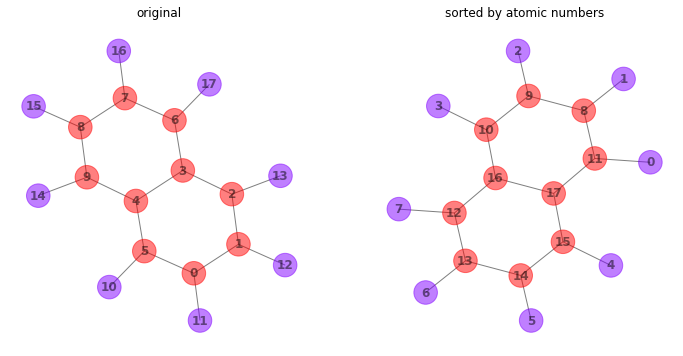

In [2]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
print_molecule(m, "original")
print_molecule(m_sorted_by_atomic_numbers, "sorted by atomic number")
draw_molecules([m, m_sorted_by_atomic_numbers], ["original", "sorted by atomic numbers"], highlight="atomic_number")

Subsequently, the molecule is partitioned by atomic numbers: elaborate on "atomic number fingerprint".


╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(11, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(8, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(9, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(10, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼────────────────────────────────────

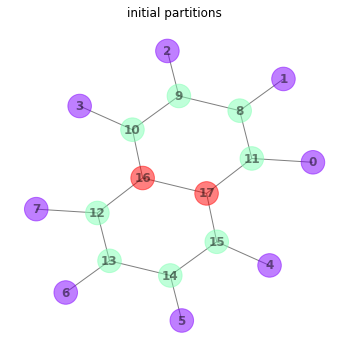

In [3]:
m_partitioned_by_atomic_numbers = partition_molecule_by_atomic_numbers(m_sorted_by_atomic_numbers)
print_molecule(m_partitioned_by_atomic_numbers)
draw_molecules([m_partitioned_by_atomic_numbers], ["initial partitions"], highlight="partition")

Now, we refine the partitions recursively ("partitioning by partition"): elaborate.

refined partitions
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(13, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(8, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(9, 6, 1)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(12, 6, 1)]                                  │
├─────────┼─────────────────┼─────────────┼──────────────────

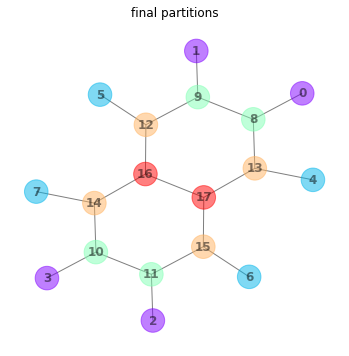

In [4]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_atomic_numbers, show_steps=True)
draw_molecules([m_partitioned], ["final partitions"], highlight="partition")

After the recursive refinement of the partitions, many partitions contain only a few molecules. This brings us closer to the ultimate goal of the canonicalization. That is, we are closer to shattering the molecule such that each atom resides in a unique partition. How do we shatter the molecule?

## Molecule traversal

Traversing molecule deterministically by branching in a principled way based on partitions.
I.e., establish branching-priorities for situations when traversal can branch to multiple neighbors from atom A:
1. neighbor with larger partition than A
2. neighbor with smaller partition than A
3. neighbor in same partition as A

During traversal, swap indices such that the current molecule A from partition P gets assigned the smallest-available index that remains in partition P (elaborate).

Current atom index: 0.	Re-labeling to 0.
Current atom index: 8.	Re-labeling to 8.
Current atom index: 13.	Re-labeling to 12.
Current atom index: 9.	Re-labeling to 9.
Current atom index: 17.	Re-labeling to 16.
Current atom index: 4.	Re-labeling to 4.
Current atom index: 12.	Re-labeling to 13.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 15.	Re-labeling to 14.
Current atom index: 16.	Re-labeling to 17.
Current atom index: 5.	Re-labeling to 5.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 11.	Re-labeling to 10.
Current atom index: 14.	Re-labeling to 15.
Current atom index: 2.	Re-labeling to 2.
Current atom index: 10.	Re-labeling to 11.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 3.	Re-labeling to 3.


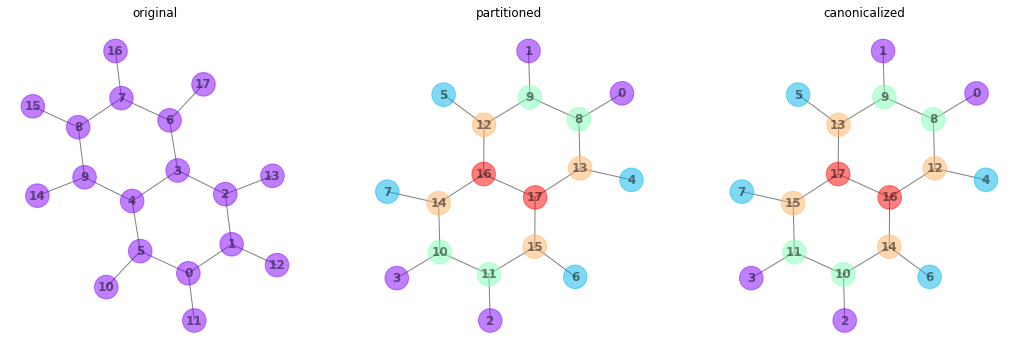

In [5]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_partitioned = partition_molecule(m)
m_partitioned = rdkit_to_nx(m_partitioned) if type(m) != nx.Graph else m
canonical_idcs = traverse_molecule(m_partitioned, 0, show_traversal_order=True)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)

draw_molecules([m, m_partitioned, m_canonicalized], ["original", "partitioned", "canonicalized"], highlight="partition")

# Invariance Test
In order to be useful for the identification of a molecule, the canonicalization must be invariant. That is, irrespective of a molecule's initial atom labels, the canonicalization should always result in the same string representation. Below we set up a simple test of invariance. 

In [6]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))
failed_molecules = {}

for _ in range(100):
    n_molecules = 0

    for molfile in testfiles:
        m = load_molfile(molfile)
        if not m: continue
        n_molecules += 1    # only count molecules that could be loaded
        permutation_seed = int(time.time())
        m_permu = permute_molecule(m, random_seed=permutation_seed)

        random.seed()
        root_atom = random.choice(range(m.GetNumAtoms()))
        m_canon = canonicalize_molecule(m, root_atom)
        m_permu_canon = canonicalize_molecule(m_permu, root_atom)

        if m_canon.edges != m_permu_canon.edges:
            if molfile.stem in failed_molecules:
                failed_molecules[molfile.stem][root_atom] = permutation_seed    # only retain latest permutation seed
            else:
                failed_molecules[molfile.stem] = {root_atom: permutation_seed}

In [7]:
print(f"\n{len(failed_molecules)}/{n_molecules} failed invariance tests:")
for molecule, test_config in failed_molecules.items():
    print(f"\n{molecule} failed with configuration(s):")
    print(test_config)


4/55 failed invariance tests:

cyclophane2 failed with configuration(s):
{31: 1642771939, 29: 1642772031, 40: 1642771942, 17: 1642772054, 6: 1642772000, 24: 1642771995, 7: 1642771950, 38: 1642771998, 21: 1642771965, 2: 1642771956, 22: 1642772016, 28: 1642771962, 15: 1642772032, 20: 1642772013, 34: 1642771970, 0: 1642772003, 39: 1642772053, 14: 1642771975, 4: 1642772046, 42: 1642772063, 37: 1642771994, 41: 1642772036, 30: 1642772006, 5: 1642772067, 25: 1642772057, 35: 1642772018, 11: 1642772023, 9: 1642772026, 19: 1642772029, 1: 1642772035, 33: 1642772040, 27: 1642772043, 16: 1642772058, 43: 1642772060, 10: 1642772064, 3: 1642772065, 26: 1642772068, 12: 1642772069}

naphthalene failed with configuration(s):
{15: 1642772052, 12: 1642772042, 17: 1642771945, 4: 1642771990, 7: 1642772047, 13: 1642771967, 16: 1642772058, 5: 1642771969, 6: 1642772053, 14: 1642772027}

decaline failed with configuration(s):
{23: 1642772030, 10: 1642771968, 12: 1642772032, 25: 1642771958, 11: 1642772039, 16: 1

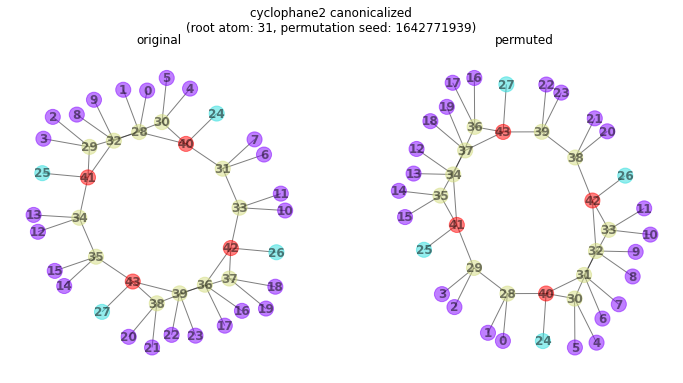

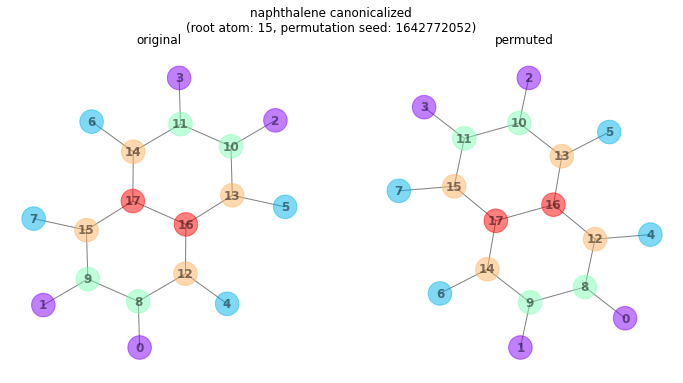

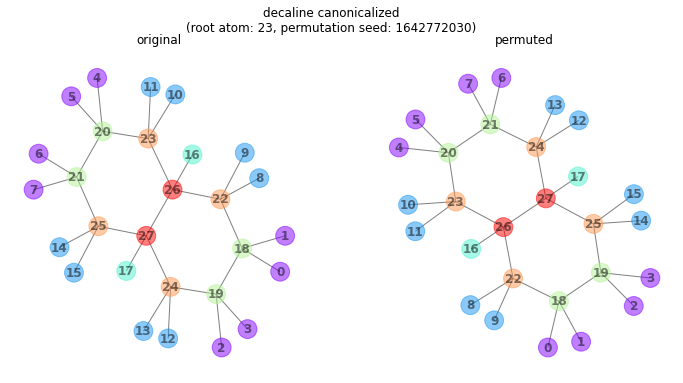

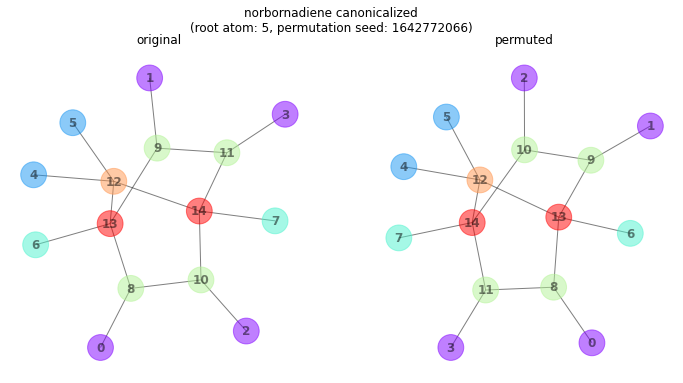

In [8]:
for molecule, test_config in failed_molecules.items():

  root_atom, permutation_seed = list(test_config.items())[0]

  m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
  m_permu = permute_molecule(m, permutation_seed)
  
  m_canon = canonicalize_molecule(m, root_idx=root_atom)
  m_permu_canon = canonicalize_molecule(m_permu, root_idx=root_atom)

  draw_molecules([m_canon, m_permu_canon], ["original","permuted"], highlight="partition",
                  title=f"{molecule} canonicalized\n(root atom: {root_atom}, permutation seed: {permutation_seed})")

Canonicalization fails when molecule traversal hits a branching point where it can only branch to multiple atoms of the same partition.